# This notebooks shows how to run ConvexML. We will use the intMEMOIR data as an example.

## First install ConvexML:

```
$ pip install convexml
```

## Using ConvexML is as simple as:

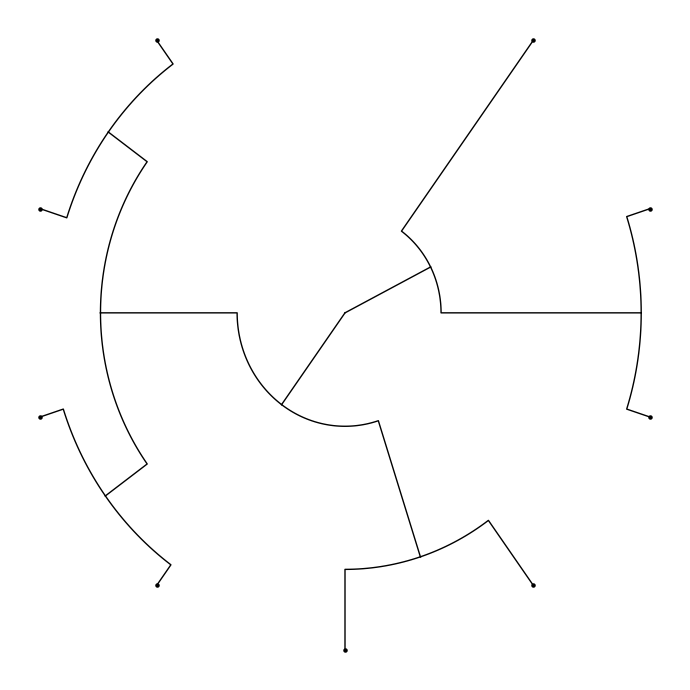

In [1]:
from convexml import convexml, plot_tree

tree_newick = "((((1,2),(3,4)),(5,6)),((8,9),10));"
leaf_sequences = {
    '10': [1, 0, 0, 2, 2, 0, 2, 2, 2, 0],
    '5': [1, 1, 0, 2, 2, 0, 2, 2, 2, 0],
    '6': [1, 1, 0, 2, 1, 0, 2, 2, 2, 0],
    '8': [2, 0, 2, 1, 1, 0, 1, 1, 2, 0],
    '9': [2, 0, 2, 1, 1, 0, 1, 1, 2, 0],
    '1': [2, 1, 0, 2, 2, 0, 2, 1, 2, 0],
    '2': [2, 0, 0, 2, 2, 0, 2, 1, 2, 0],
    '3': [2, 0, 0, 2, 2, 0, 2, 1, 2, 0],
    '4': [2, 0, 0, 2, 2, 0, 2, 1, 2, 0],
}

tree_newick = convexml(
    tree_newick=tree_newick,
    leaf_sequences=leaf_sequences,
    minimum_branch_length=0.15,  # (We assume that the tree has a height of exactly 1.0)
)["tree_newick"]

plot_tree(tree_newick)

# NOTES:

- The uncut state is represented as 0.
- Missing data is encoded as -1.
- `minimum_branch_length` represents the minimum branch length as a _fraction_ of the total tree height. In other words, we assume that the tree has height exactly 1.
- For leaf edges, half of the `minimum_branch_length` value will be used, i.e. 0.075 in the example. This is because in the application of single-cell lineage tracing, leaf nodes do not represent cell division events. You can change this behaviour by passing `pendant_branch_minimum_branch_length_multiplier=1.0` (by default it is 0.5). Try it in the example above -- you will notice how the leaf edges get longer!
- By default, pseudocounts are used when estimating branch lengths. There are two kinds of pseudocounts: `pseudo_mutations_per_edge` and `pseudo_non_mutations_per_edge`. By default, they are both equal to `0.1`. You can change these by passing their desired values to the function. Try setting `minimum_branch_length=0, pseudo_mutations_per_edge=0, pseudo_non_mutations_per_edge=0` in the code above, thus turning off _all_ regularization. You will see how some of the estimated edge lengths are zero! Regularization is a key element to the success of ConvexML on real single-cell lineage tracing datasets.
- You can provide your own ancestral sequences with the `ancestral_sequences` argument. In this case, your newick tree should label the internal nodes too or else you will get an error.
- We use conservative maximum parsimony to reconstruct ancestral states by default. If you want to use standard maximum parsimony, pass in `ancestral_state_reconstructor=maximum_parsimony` instead. While `maximum_parsimony` and `conservative_maximum_parsimony` agree when there is no missing data, in the presence of missing data `maximum_parsimony` may start injecting noticeable bias in the branch length estimates, as it basically propagates mutations greedily up the tree -- to far up. Instead, `conservative_maximum_parsimony` accounts for the possibility that mutations may have occurred lower on the tre.
- If your tree has multifurcation, you may want to resolve them into an arbitrary binary structure. For that, use `resolve_multifurcations_before_branch_length_estimation=True`. If you want to resolve multifurcations _only_ for the purpose of branch length estimation (i.e. you don't want the output tree topology to change in any way), pass in `recover_multifurcations_after_branch_length_estimation=True`. This is the default behavior. Doing it this way ensures more effective regularization, since multifurcations indicate the existence of more internal nodes (e.g. cell divisions) which we can apply the minimum branch length and pseudocount constraints to.
- You can estimate branch lengths for _non-ultrametric_ trees too. Just pass in the `relative_leaf_depth`, which specifies the relative depth of each leaf in your tree. Try it out on the example above, for example by passing in `relative_leaf_depth=[("1", 0.55), ("2", 0.6), ("3", 0.65), ("4", 0.7), ("5", 0.75), ("6", 0.8), ("8", 0.9), ("9", 0.95), ("10", 1.0)]`.
- You can specify the relative mutation rate of each site using `relative_mutation_rates`. For example, try using `relative_mutation_rates=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`. Generally, we haven't so far found that modeling site rate variation gives improvements.
- Our method does not attempt to collapse edges without supported mutations prior to branch length estimation. If you would like to do this, you may use the `tree.collapse_mutationless_edges(infer_ancestral_characters=True)` method of the `CassiopeiaTree` object.
- Our API uses newick strings to make it more broadly applicable. If you are using the `cassiopeia` package, you may convert a `CassiopeiaTree` into the newick format by using `from convexml import to_newick` and then `tree_newick=to_newick(tree_cassiopeia.get_tree_topology(), record_node_names=True)`. Furthermore, `convexml` returns the `CassiopeiaTree` with estimated branch lengths in the `"tree_cassiopeia"` field of its return dictionary.